# 05 - Results

In [139]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping

from models.X_RCC import XRCC, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

In [140]:
# -- FREE PARAMETERS
n_seasons   = 2
n_iters     = 100

In [141]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Path for results
clustering_results_path  = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters.nc'
literature_results_path  = f'../data/preprocessed/external/monsoon_dates.nc'

results_path_image  = f'../data/results/images/bias_results_{n_iters}iters.png'
results_path_image_centered  = f'../data/results/images/bias_results_{n_iters}iters_centered.png'

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

# Mask boundary
mask_boundary = world_boundary[world_boundary["GID_0"].isin(['IND','NPL','BGD'])]

In [142]:
clustering_results = xr.open_dataset(clustering_results_path)
literature_results = xr.open_dataset(literature_results_path)

In [143]:
a = clustering_results.sel(cluster=0).__xarray_dataarray_variable__
b = literature_results.sel(cluster=0).date
onset_diff = (b-a).rename('Bias').drop(['spatial_ref']).assign_coords(season_idx='onset')

a = a-a.mean()
b = b-b.mean()
onset_diff_centered = (b-a).rename('Bias').drop(['spatial_ref']).assign_coords(season_idx='onset')

a = clustering_results.sel(cluster=1).__xarray_dataarray_variable__
b = literature_results.sel(cluster=1).date
withdrawal_diff = (b-a).rename('Bias').drop(['spatial_ref']).assign_coords(season_idx='withdrawal')

a = a-a.mean()
b = b-b.mean()
withdrawal_diff_centered = (b-a).rename('Bias').drop(['spatial_ref']).assign_coords(season_idx='withdrawal')

tota = xr.concat([onset_diff,withdrawal_diff], dim='season_idx')
tota_centered = xr.concat([onset_diff_centered, withdrawal_diff_centered], dim='season_idx')

In [144]:
# plot = tota.plot.contourf(col='season_idx', col_wrap=2, vmin=-30, vmax=30, levels=4, add_colorbar=False, figsize=(9,4), cmap='coolwarm')

# standard_format( plot,
#                  country_boundary   = country_boundary,
#                  world_boundary     = world_boundary,
#                  custom_cbar        = True
#                 )

# plot.axes[0][0].set_title('Onset Bias', size=12)
# plot.axes[0][1].set_title('Withdrawal Bias', size=12)
# plot.cbar.set_label('Bias [days]')


# plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)

In [145]:
# plot = tota_centered.plot.contourf(col='season_idx', col_wrap=2, vmin=-30, vmax=30, levels=4, add_colorbar=False, figsize=(9,4), cmap='coolwarm')

# standard_format( plot,
#                  country_boundary   = country_boundary,
#                  # world_boundary     = world_boundary,
#                  custom_cbar        = True
#                 )

# plot.axes[0][0].set_title('Onset Bias - Centered', size=12)
# plot.axes[0][1].set_title('Withdrawal Bias - Centered', size=12)
# plot.cbar.set_label('Bias [days]')

# # plt.savefig(results_path_image_centered, dpi=300, bbox_inches='tight', transparent=False)

In [146]:
dataset_tp = xr.open_mfdataset(rf'/work/users/jgrassi/Radially_constrained_clustering/data/India/ERA5/preprocessed/total_precipitation/precipitation_1980_2011_15dd.nc').tp.load().groupby('time.dayofyear').mean() * 24*1000

In [148]:
mask = world_boundary[world_boundary.COUNTRY=='Bangladesh']

# Masking the dataset to remove sea points
dataset_tp_masked = dataset_tp.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
dataset_tp_masked.rio.write_crs("epsg:4326", inplace=True)
dataset_tp_masked = dataset_tp_masked.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)



In [149]:
clustering_result_masked = clustering_results.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
clustering_result_masked.rio.write_crs("epsg:4326", inplace=True)
clustering_result_masked = clustering_result_masked.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

literature_result_masked = literature_results.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
literature_result_masked.rio.write_crs("epsg:4326", inplace=True)
literature_result_masked = literature_result_masked.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

In [150]:
cluster_mean = clustering_result_masked.sel(cluster=0).mean().__xarray_dataarray_variable__.values
literature_mean = literature_result_masked.sel(cluster=0).mean().date.values

<Axes: title={'center': 'dayofyear = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

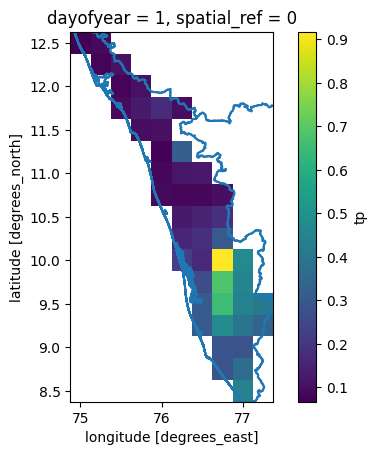

In [151]:
fig, ax = plt.subplots(1,1)
dataset_tp_masked.isel(dayofyear=0).plot(ax = ax)
country_boundary.boundary.plot(ax=ax)

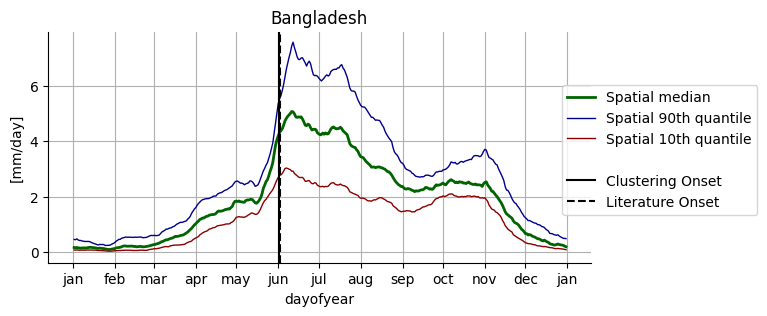

In [152]:
fig, ax = plt.subplots(1,1, figsize=(7,3))

dataset_tp_masked.quantile(0.5,['lat','lon']).plot(ax=ax, lw = 2, c = 'darkgreen', label='Spatial median')
dataset_tp_masked.quantile(0.90,['lat','lon']).plot(ax=ax, lw = 1, c = 'darkblue', label='Spatial 90th quantile')
dataset_tp_masked.quantile(0.10,['lat','lon']).plot(ax=ax, lw = 1, c = 'darkred', label='Spatial 10th quantile')

ax.plot([0],[0], label=' ', c='none')
ax.axvline(cluster_mean, color='k', label='Clustering Onset')
ax.axvline(literature_mean, color='k', linestyle='--', label='Literature Onset')

ax.legend(ncol=1, loc='upper right', fancybox=True, bbox_to_anchor=(1.32, 0.8))

ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Bangladesh')
ax.set_ylabel('[mm/day]')
ax.set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])

In [172]:
def region_cycle_plot(mask, name):
     
    # Masking the dataset to remove sea points
    dataset_tp_masked = dataset_tp.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    dataset_tp_masked.rio.write_crs("epsg:4326", inplace=True)
    dataset_tp_masked = dataset_tp_masked.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

    clustering_result_masked = clustering_results.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    clustering_result_masked.rio.write_crs("epsg:4326", inplace=True)
    clustering_result_masked = clustering_result_masked.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

    literature_result_masked = literature_results.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    literature_result_masked.rio.write_crs("epsg:4326", inplace=True)
    literature_result_masked = literature_result_masked.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

    cluster_mean = clustering_result_masked.sel(cluster=0).mean().__xarray_dataarray_variable__.values
    literature_mean = literature_result_masked.sel(cluster=0).mean().date.values

    fig, ax = plt.subplots(1,2, figsize = (12, 3), gridspec_kw={'width_ratios': [1, 3]})

    country_boundary.boundary.plot(ax = ax[0], color='k', lw=0.2)
    mask.boundary.plot(ax = ax[0], color='red', lw=1)
    mask.plot(ax = ax[0], color='red')
    ax[0].set_ylabel('Latitude [°N]')
    ax[0].set_xlabel('Longitude [°E]')


    dataset_tp_masked.quantile(0.5,['lat','lon']).plot(ax=ax[1], lw = 2, c = 'darkgreen', label='Spatial median')
    dataset_tp_masked.quantile(0.90,['lat','lon']).plot(ax=ax[1], lw = 1, c = 'darkblue', label='Spatial 90th quantile')
    dataset_tp_masked.quantile(0.10,['lat','lon']).plot(ax=ax[1], lw = 1, c = 'darkred', label='Spatial 10th quantile')

    ax[1].plot([0],[0], label=' ', c='none')
    ax[1].axvline(cluster_mean, color='k', label='Clustering Onset')
    ax[1].axvline(literature_mean, color='k', linestyle='--', label='Literature Onset')

    ax[1].legend(ncol=1, loc='upper right', fancybox=True, bbox_to_anchor=(1.32, 0.8))

    for ax_s in ax.ravel():
        ax_s.grid()
        ax_s.spines['top'].set_visible(False)
        ax_s.spines['right'].set_visible(False)
    


    ax[1].set_title('')
    ax[1].set_ylabel('[mm/day]')
    ax[1].set_xlabel('Month')
    ax[1].set_xticks([0,31,60,91,121,152,182,213,244,274,305,335,366],['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','jan'])
    fig.suptitle(name)


    return fig


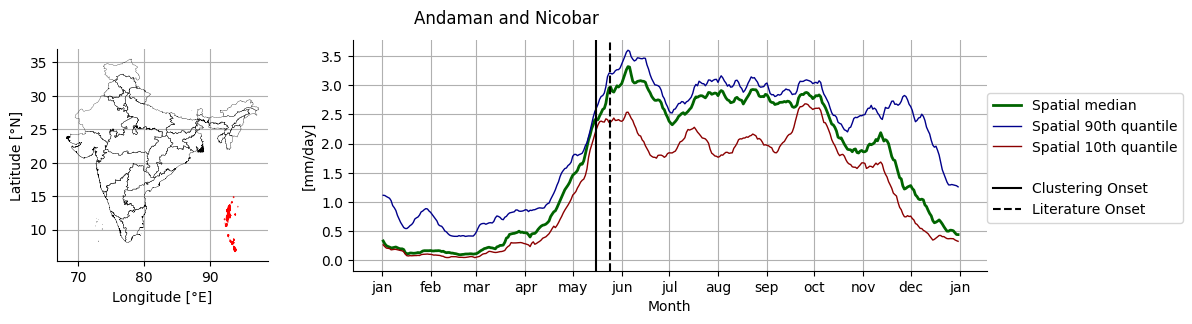

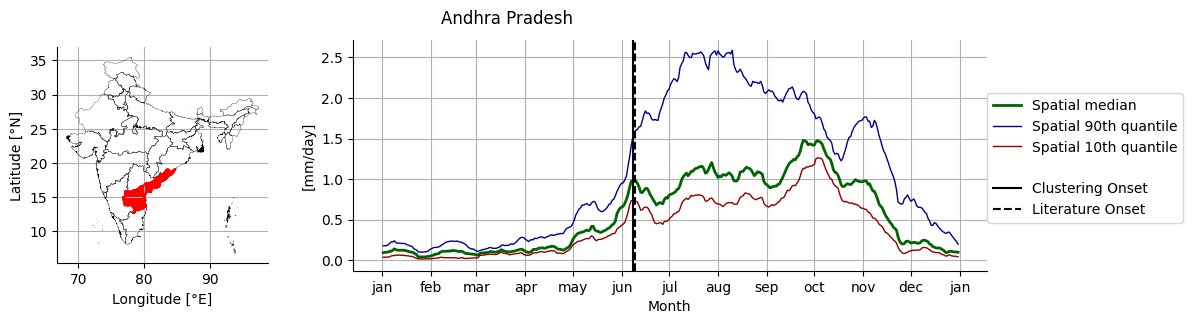

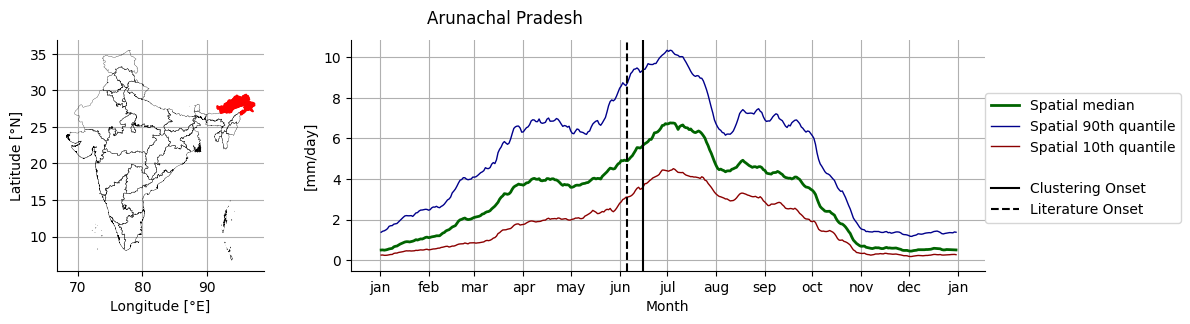

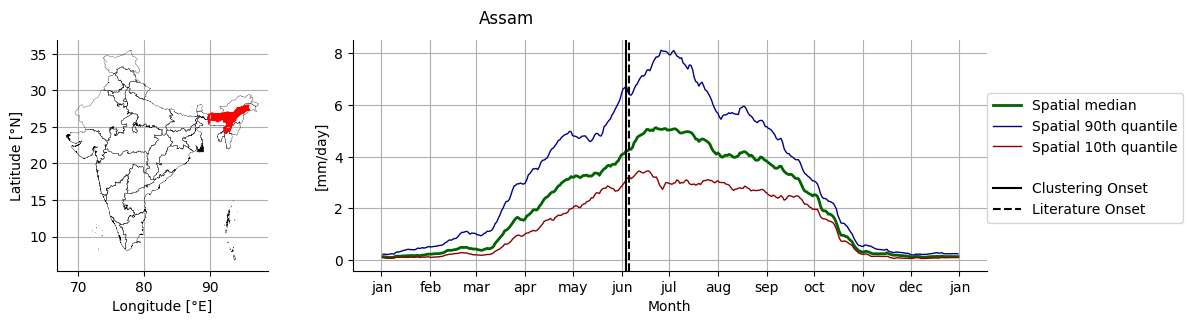

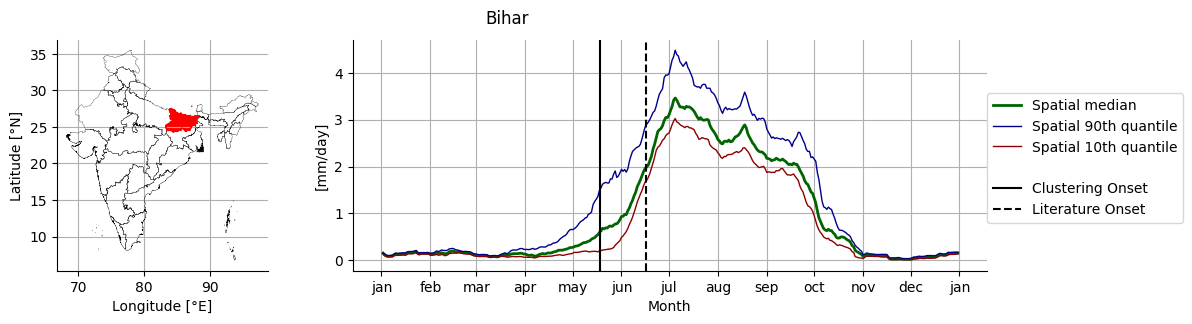

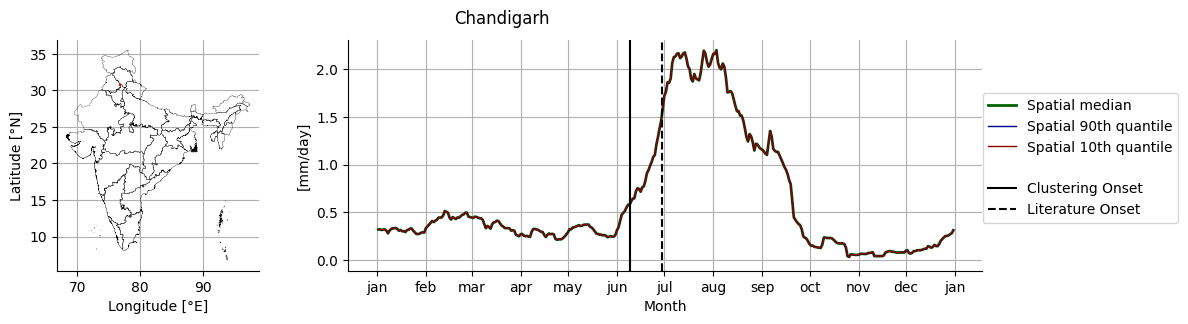

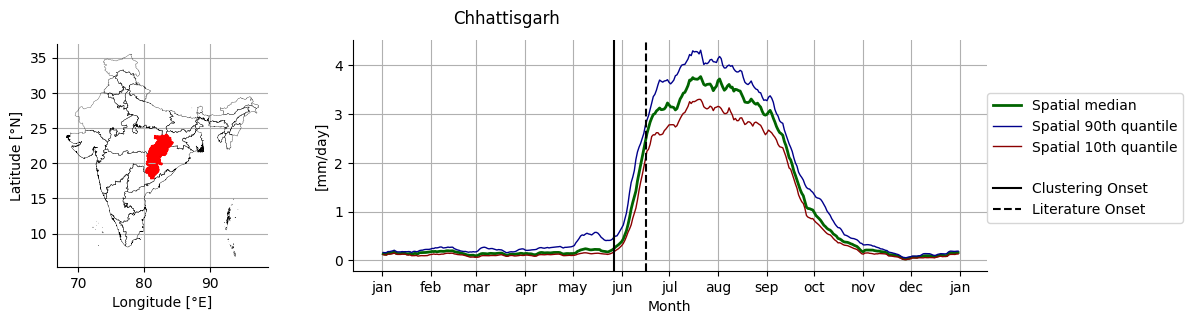

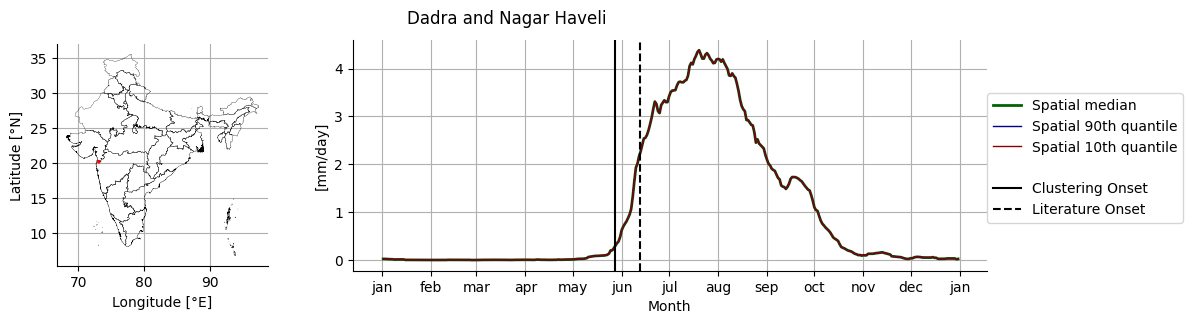

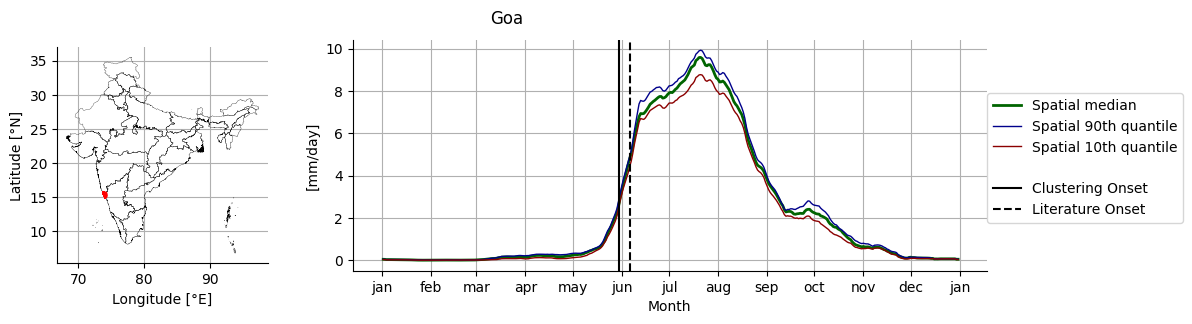

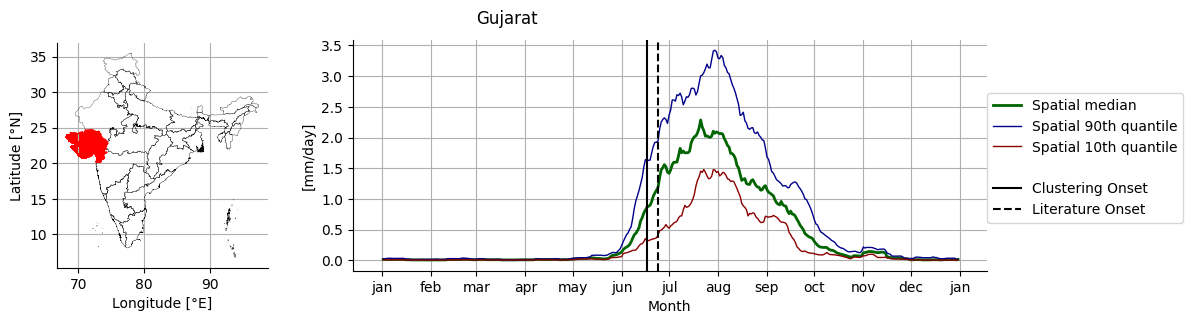

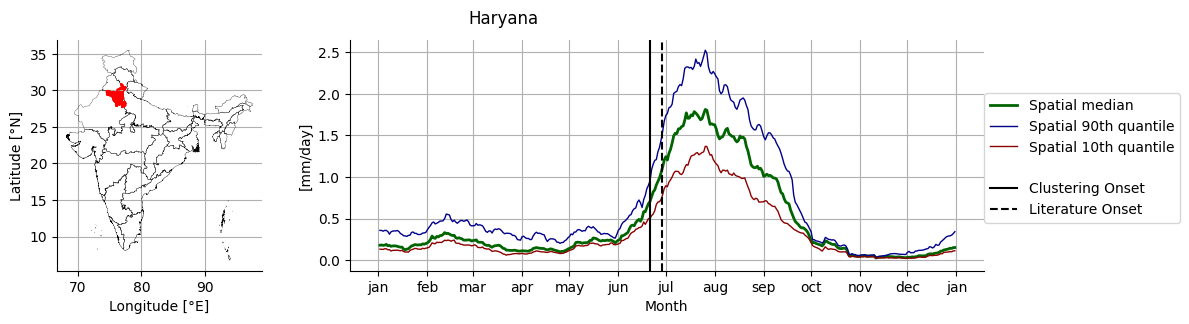

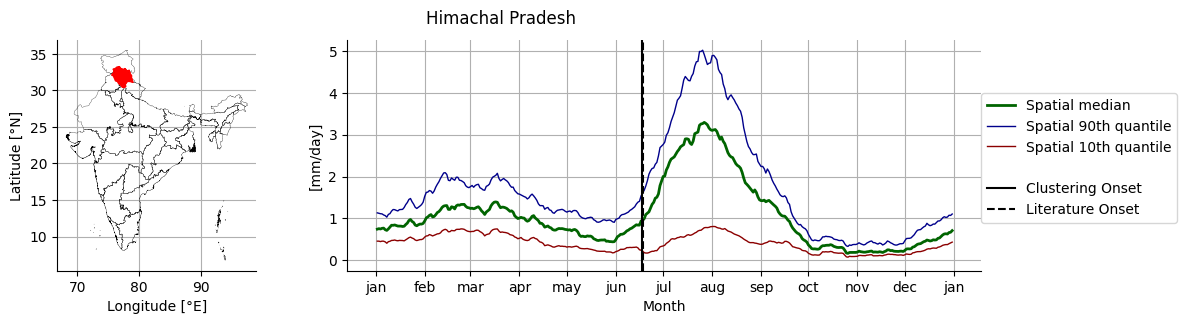

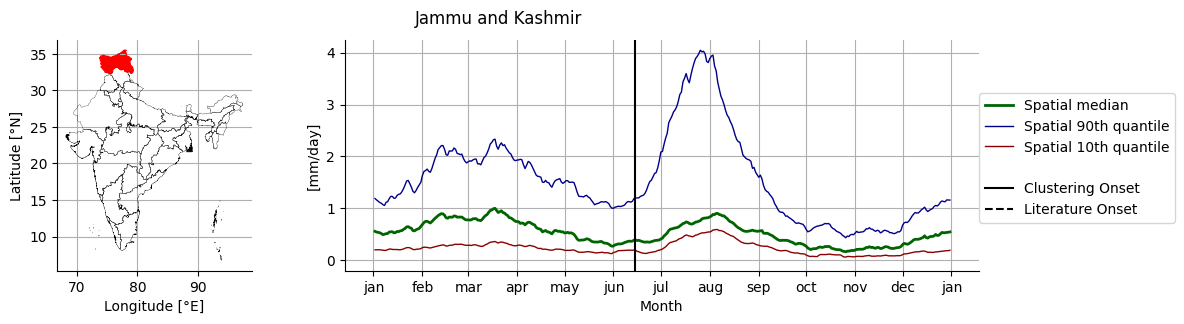

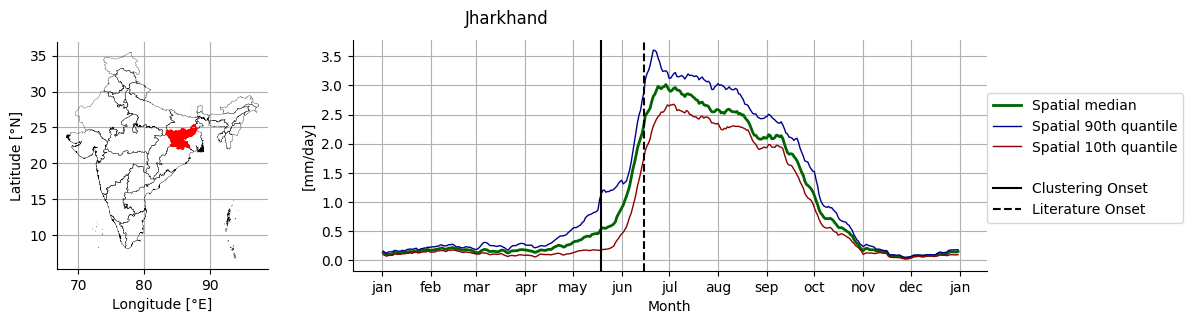

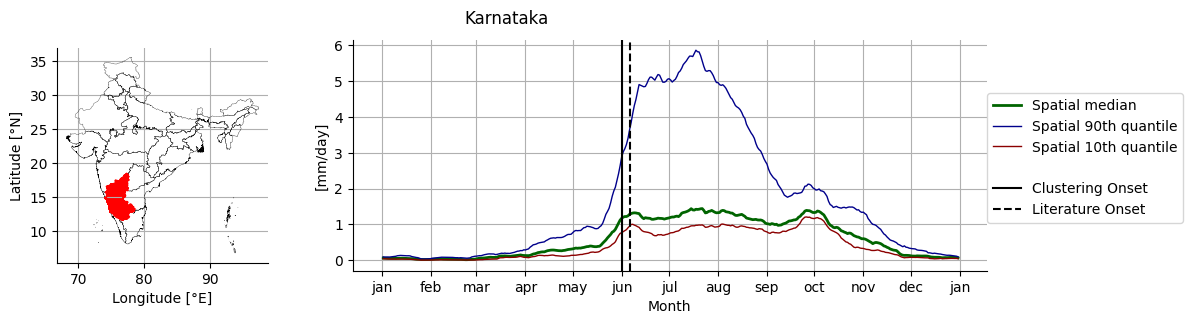

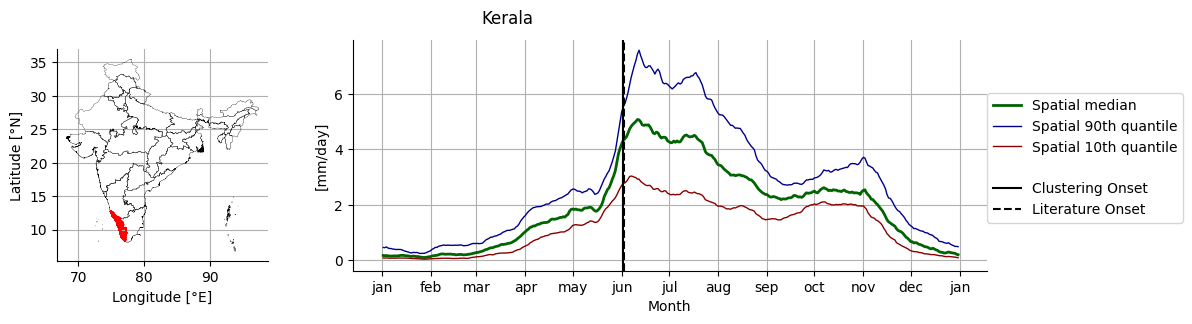

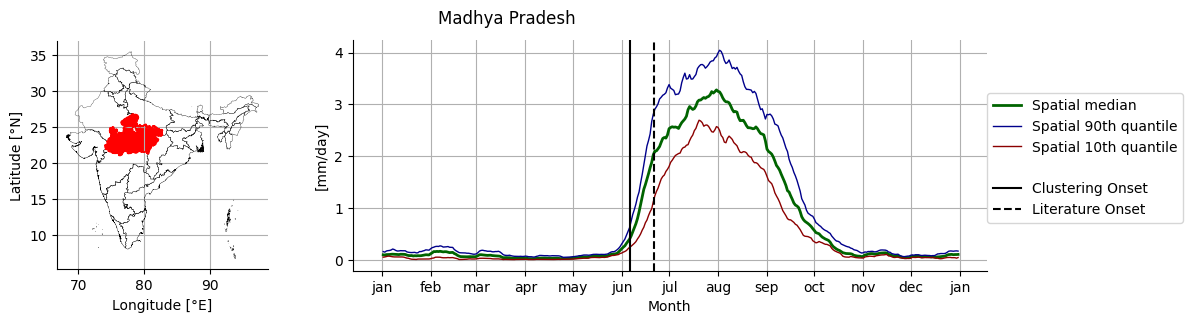

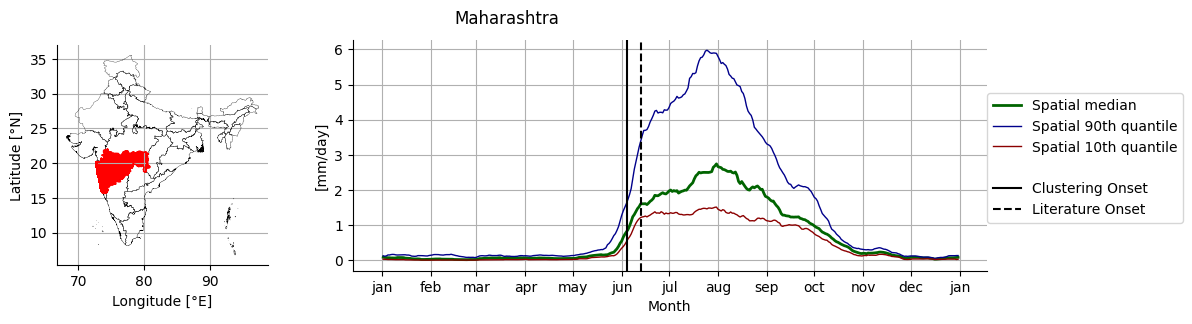

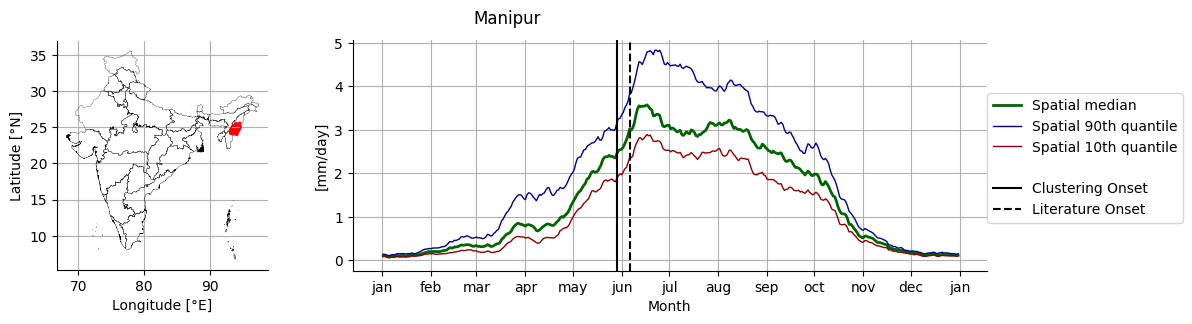

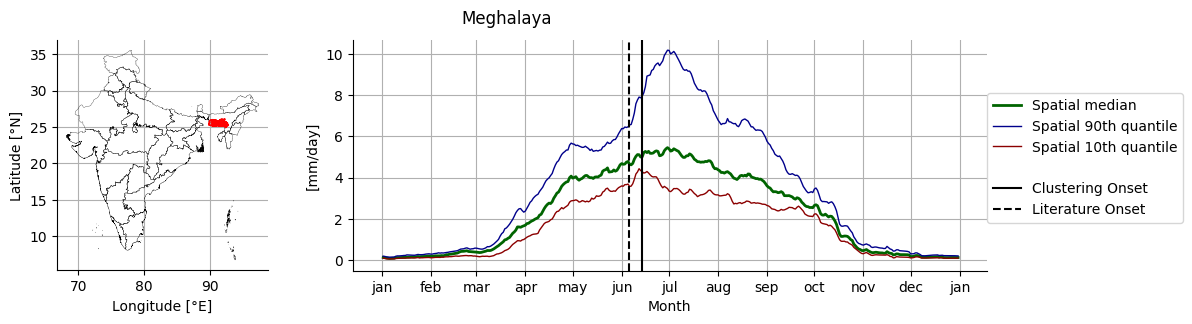

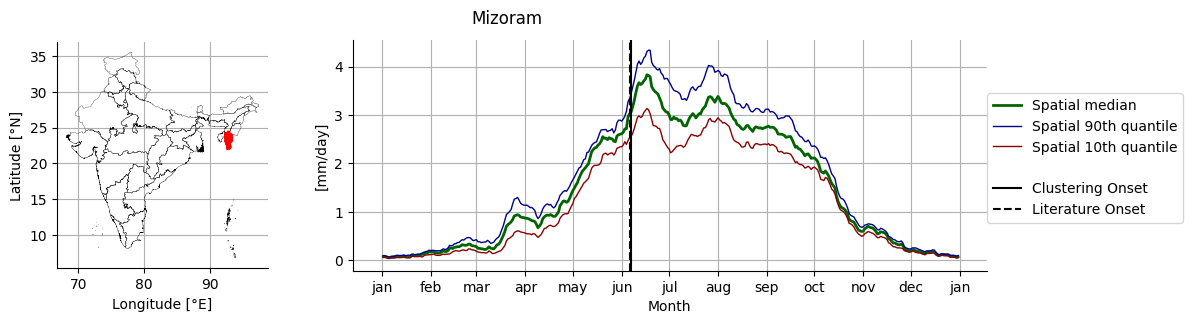

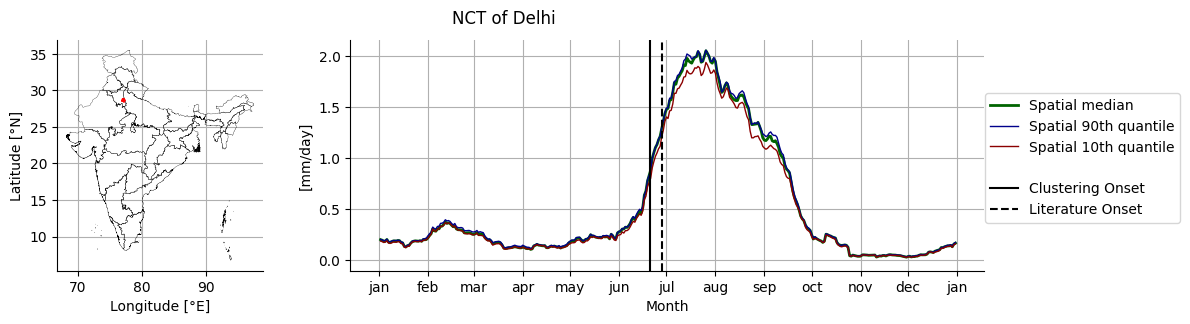

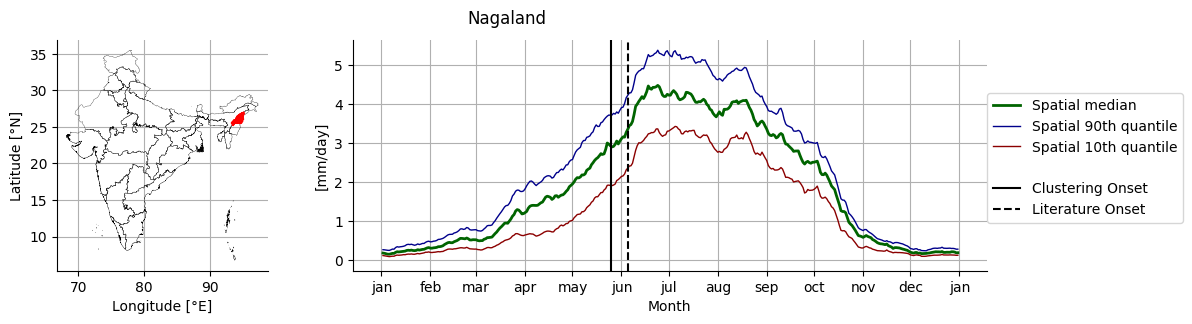

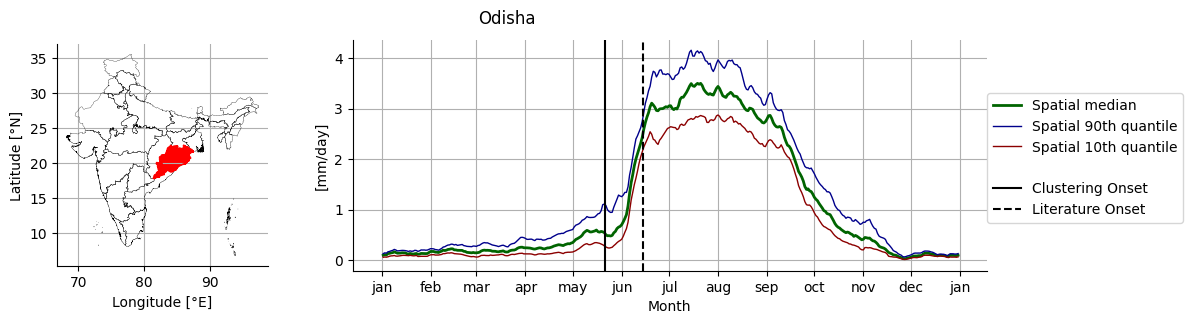

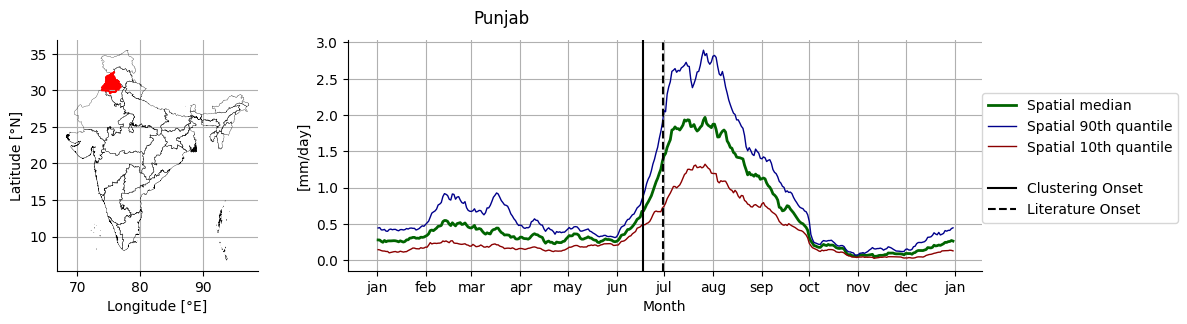

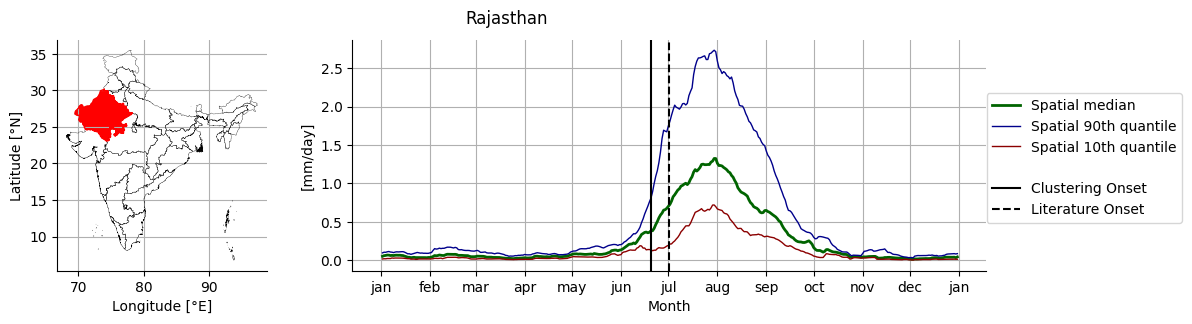

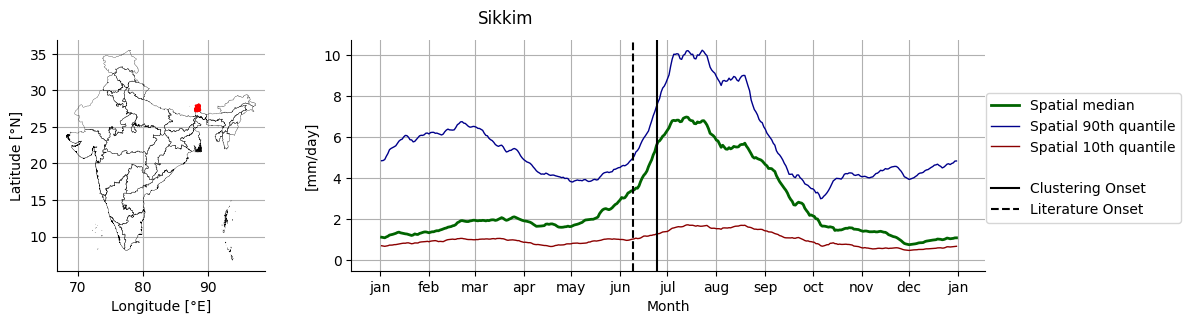

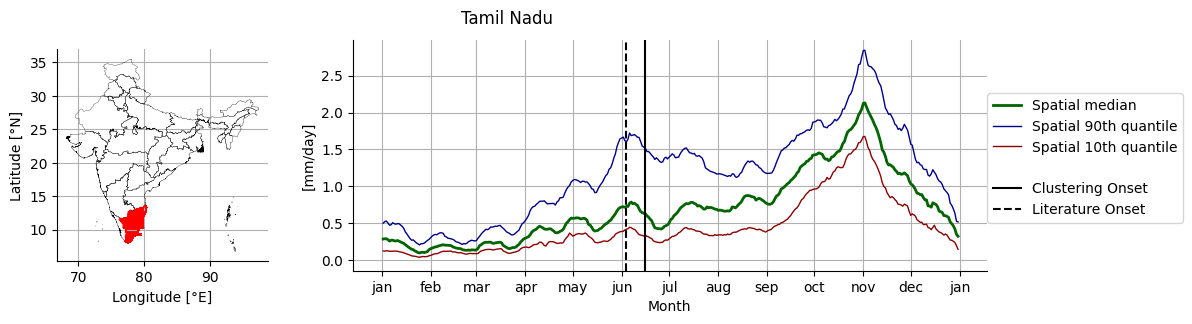

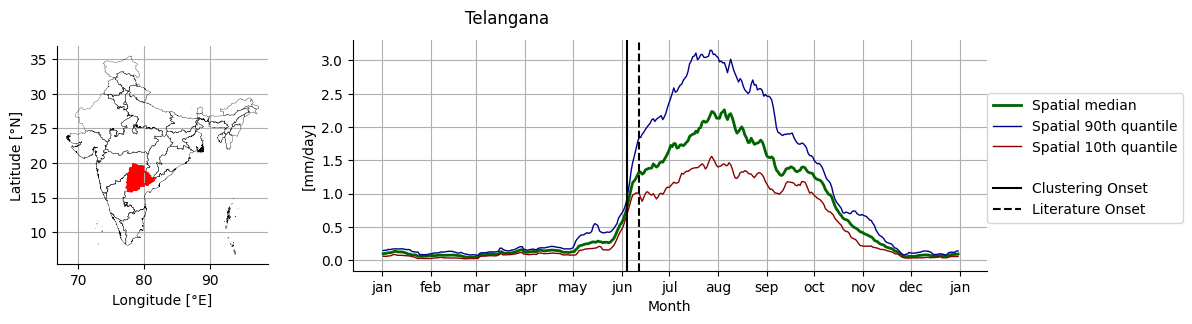

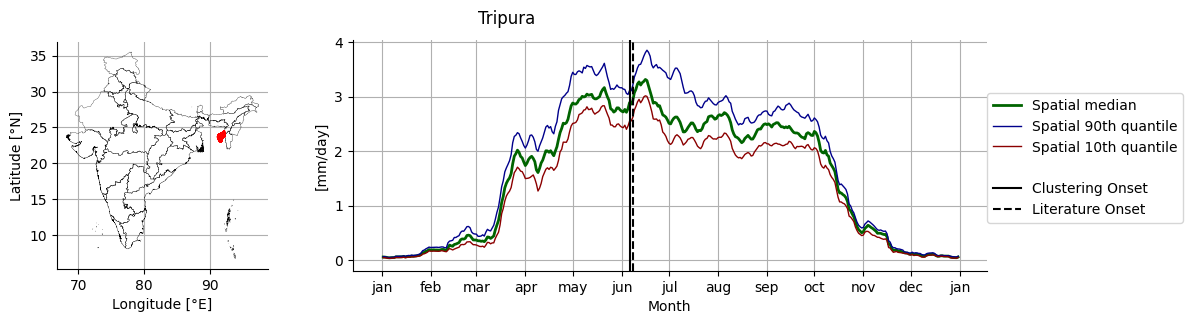

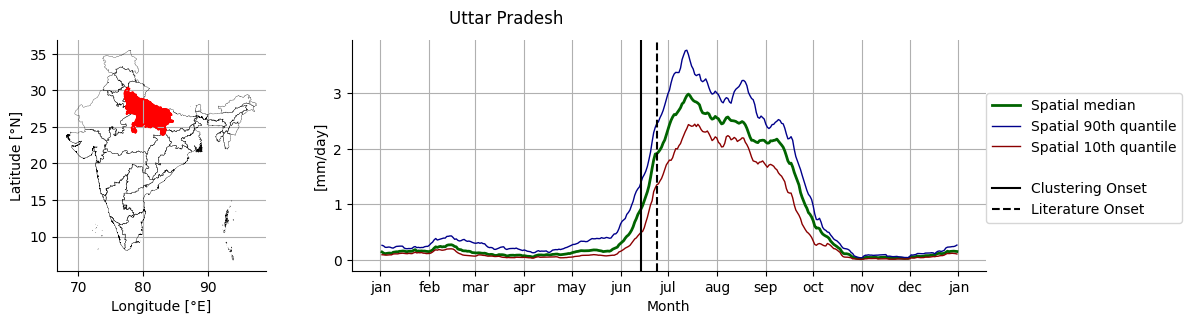

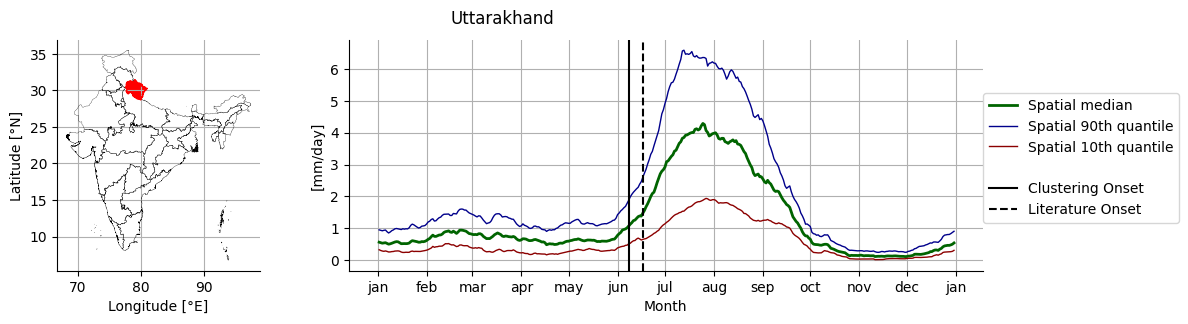

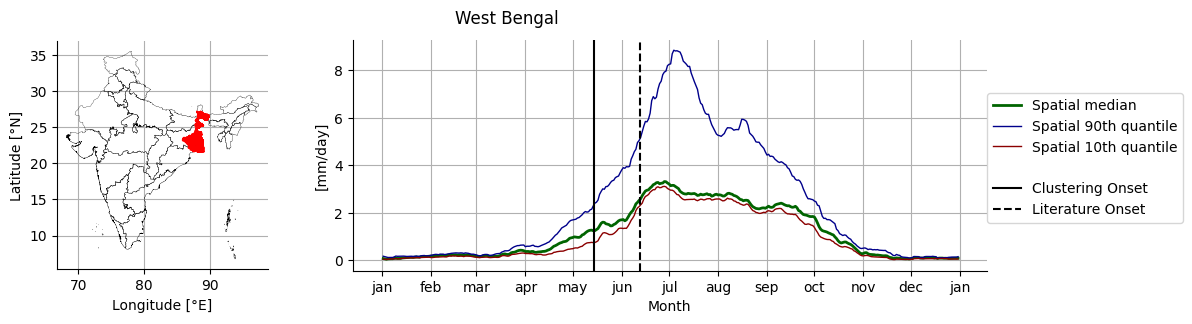

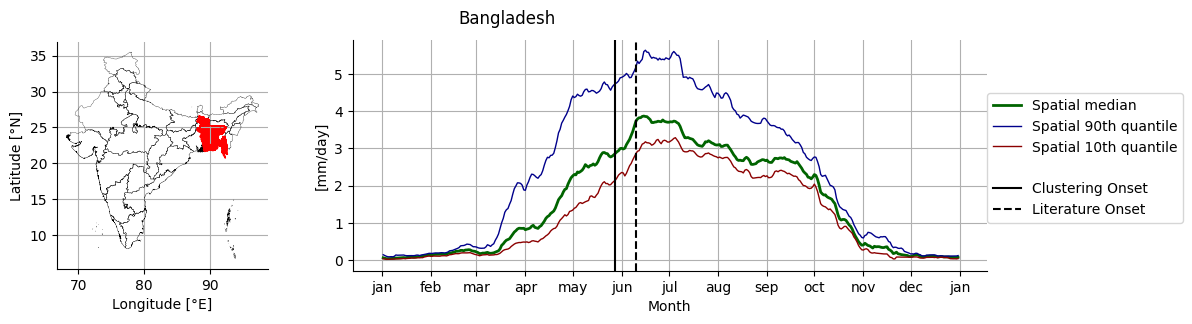

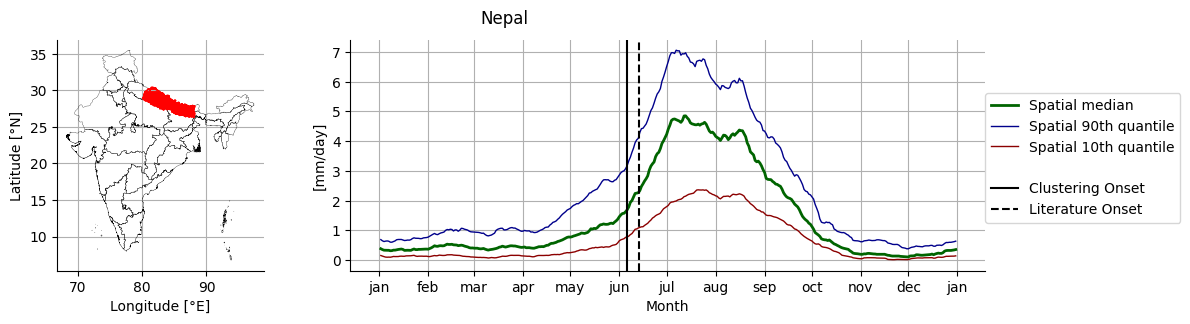

In [173]:
for country_name in np.unique(country_boundary.NAME_1):

    try:

        mask = country_boundary[country_boundary.NAME_1 == country_name]
        fig  = region_cycle_plot(mask, country_name)
        fig.savefig(f'../data/results/images/cycles/{country_name}.png', dpi=300, bbox_inches='tight', transparent=False)

    except:
        pass


fig = region_cycle_plot(world_boundary[world_boundary.COUNTRY=='Bangladesh'], 'Bangladesh')
fig.savefig(f'../data/results/images/cycles/Bangladesh.png', dpi=300, bbox_inches='tight', transparent=False)

fig = region_cycle_plot(world_boundary[world_boundary.COUNTRY=='Nepal'], 'Nepal')
fig.savefig(f'../data/results/images/cycles/Nepal.png', dpi=300, bbox_inches='tight', transparent=False)